Partie 1
#Chargement des données 

In [456]:
import pandas as pd
import re

def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'

# Patterns for extracting train and test data
train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'

# Extracting train and test data
rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(len(train_df))
print(len(test_df)) 


104
104


Partie 2

## Apprentissage sur train

In [457]:
import numpy as np

def perceptron_batch(training_features, training_labels, epochs=650, learning_rate=0.01):
    """
    Entraîne un perceptron en utilisant l'algorithme batch.

    :param training_features: numpy.ndarray, les caractéristiques d'entraînement.
    :param training_labels: numpy.ndarray, les étiquettes d'entraînement (doivent être -1 ou 1).
    :param threshold: int, le nombre d'itérations pour l'entraînement.
    :param learning_rate: float, le taux d'apprentissage.
    :return: numpy.ndarray, les poids appris.
    """
    # Initialisation des poids
    weights = np.zeros(training_features.shape[1] + 1)
    
    # Entraînement
    for _ in range(epochs):
        # Initialisation du vecteur de mise à jour pour cette époque
        update = np.zeros(training_features.shape[1] + 1)
        
        for inputs, label in zip(training_features, training_labels):
            # Calcul de la prédiction
            activation = np.dot(inputs, weights[1:]) + weights[0]
            if activation >= 0:
                prediction = 1
            else:
                prediction = -1
            
            # Accumulation de la mise à jour basée sur l'erreur
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        
        # Mise à jour des poids à la fin de l'époque
        weights += update
    
    return weights

# Préparation des données
# Supposons que train_df est déjà défini et mélangé
# Convertir les étiquettes 'R' et 'M' en valeurs numériques -1 et 1
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparation des caractéristiques et des étiquettes
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values
print(test_labels)

# Séparation des caractéristiques et des étiquettes
train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values
print(train_labels)
# Entraînement du perceptron
weights = perceptron_batch(train_features, train_labels)

print(weights)


[-1 -1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1 -1  1  1 -1
 -1  1 -1  1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1  1  1 -1  1  1 -1  1 -1
 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1 -1  1  1 -1  1  1 -1  1  1  1
 -1 -1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1  1  1
 -1  1  1  1  1 -1  1 -1]
[ 1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1
  1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1
 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1
  1 -1  1  1  1  1 -1  1]
[-5.64      1.494286  2.956714  1.893002  3.201548  3.988028  2.340756
 -0.170046 -3.55322   1.092888  2.533972  4.828372  2.397392  1.803896
  1.565808  0.327156 -5.10859  -2.097738  1.30256   1.077734 -1.246864
  0.507828  1.59125  -0.761862  1.415848  0.104242  0.02564  -0.740562
 -0.202982  1.957592  2.18339  -5.754716  1.425072  0.02868  -1.274088
 -0.24649

Test sur l'ensemble de test

In [458]:
# Supposons que `weights` est le vecteur de poids appris du perceptron
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1

# Supposons que test_df contient uniquement les caractéristiques sans les étiquettes
test_features = test_df.iloc[:, :60].values  # Sélectionne uniquement les colonnes de caractéristiques

# Faire des prédictions
predictions = [predict_perceptron(x, weights) for x in test_features]

# Affichage des prédictions
print(predictions)


[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1]


Calcul de Ea et de Eg

In [459]:
# Fonction pour calculer la précision
def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

# Convertir les étiquettes de l'ensemble de test en valeurs numériques -1 et 1
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparer les caractéristiques et les étiquettes de l'ensemble de test
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

# Calculer la précision sur l'ensemble d'entraînement et de test
training_accuracy = calculate_accuracy(features, labels, weights)
testing_accuracy = calculate_accuracy(test_features, test_labels, weights)

# Calculer les erreurs d'apprentissage (Ea) et de généralisation (Eg)
Ea = 1 - training_accuracy
Eg = 1 - testing_accuracy

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")

print("\n Poids appris du perceptron :")
print(weights)

Erreur d'apprentissage (Ea) : 0.29807692307692313
Erreur de généralisation (Eg) : 0.2596153846153846

 Poids appris du perceptron :
[-5.64      1.494286  2.956714  1.893002  3.201548  3.988028  2.340756
 -0.170046 -3.55322   1.092888  2.533972  4.828372  2.397392  1.803896
  1.565808  0.327156 -5.10859  -2.097738  1.30256   1.077734 -1.246864
  0.507828  1.59125  -0.761862  1.415848  0.104242  0.02564  -0.740562
 -0.202982  1.957592  2.18339  -5.754716  1.425072  0.02868  -1.274088
 -0.246492 -3.29898  -2.609384  2.747962  1.053258 -3.698224  0.794434
 -0.074728  0.07778   2.192948  4.801626  3.360534  3.025102  4.536054
  4.117864 -0.16807   0.531794  0.480176  0.232716  0.528076 -0.160308
 -0.05752  -0.23955   0.326474  0.225474  0.052214]


- ### C) Calculer les stabilités des P exemples de « test » selon la formule de gamma (distance a l’hyperplan séparateur avec les poids normés)

In [460]:
import numpy as np

def calculate_stabilities(test_features, test_labels, weights):
    """
    Calcule la stabilité de chaque exemple de test.

    :param test_features: numpy.ndarray, les caractéristiques de test (sans biais ajouté).
    :param test_labels: numpy.ndarray, les étiquettes de test (-1 ou 1).
    :param weights: numpy.ndarray, les poids appris (y compris le biais).
    :return: numpy.ndarray, les stabilités de chaque exemple de test.
    """
    # Séparation du poids du biais et des poids des caractéristiques
    b, w = weights[0], weights[1:]
    
    # Calcul de la norme des poids (sans le biais)
    norm_w = np.linalg.norm(w)
    
    # Calcul des activations (y_i * (w . x_i + b))
    activations = test_labels * (np.dot(test_features, w) + b)
    
    # Calcul des stabilités (activation / norm_w)
    stabilities = activations / norm_w
    
    return stabilities

# Supposons que test_df est déjà défini et contient les données de test
# Conversion des étiquettes 'R' et 'M' en -1 et 1 pour les données de test
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparation des caractéristiques et des étiquettes pour les données de test
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

# Calcul des stabilités
stabilities = calculate_stabilities(test_features, test_labels, weights)

# Affichage des stabilités
print("Stabilités des exemples de test :")
print(stabilities)


Stabilités des exemples de test :
[ 0.29466534  0.31836255  0.12062277  0.10627179  0.03086409 -0.28112954
  0.4981367   0.13930754  0.12558862  0.03302966  0.30927429  0.24833667
  0.01007485 -0.2251627  -0.11881931  0.17809982 -0.20599282  0.22758456
 -0.00705391  0.21743219  0.28365681  0.27361878 -0.16657451  0.34872243
  0.20677133  0.16188867  0.32257013  0.00847662  0.2571353   0.00652868
  0.26531592 -0.13953328  0.15165054  0.22546715  0.03473821  0.43927665
 -0.03396545 -0.37184477  0.39248186 -0.1386972   0.09277681 -0.04274625
  0.47235635 -0.02614949  0.03375871  0.15250837  0.07786912  0.28581601
  0.48041133  0.17877266  0.00793809  0.12080523  0.27981981  0.02154353
  0.27400147  0.10035768  0.1614813  -0.04215328  0.05695216 -0.16295033
 -0.08191579 -0.05790533  0.32165871  0.21085309 -0.34335952  0.12726808
  0.22744622  0.11488708  0.28943122 -0.0202661   0.05011603 -0.0164231
  0.19702652  0.55240042 -0.10198683  0.08457264  0.09101883  0.25267805
  0.01154009  0.21

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1 -1  1  1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1
  1  1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1
 -1 -1  1 -1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1  1
 -1 -1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1
  1  1 -1  1 -1 -1  1  1]


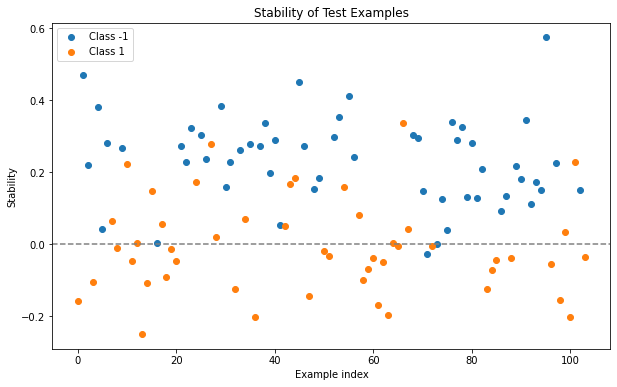

In [461]:
import numpy as np
import matplotlib.pyplot as plt

print(test_labels)
print(train_labels)

# Exemple des caractéristiques des exemples de test
test_features = train_df.iloc[:, :-1].values

# Exemple des étiquettes réelles des exemples de test
test_labels = train_df.iloc[:, -1].values

# Normalize the weights (excluding the bias term)
norm_weights = np.linalg.norm(weights[1:])

# Calculate the signed distance from the decision boundary for each example
signed_distances = (np.dot(test_features, weights[1:]) + weights[0]) / norm_weights

# Multiply by labels to get stabilities
stabilities = signed_distances * test_labels

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(test_labels):
    plt.scatter(np.arange(len(stabilities))[test_labels == label], stabilities[test_labels == label], label=f'Class {label}')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Example index')
plt.ylabel('Stability')
plt.title('Stability of Test Examples')
plt.legend()
plt.show()

- ## D) Graphique des stabilités


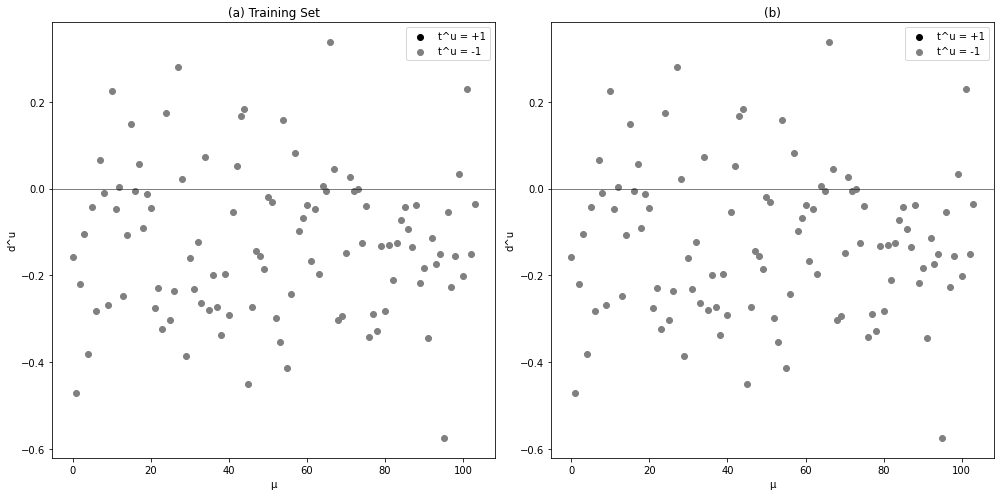

In [462]:
d = signed_distances

# Plot the data
plt.figure(figsize=(14, 7))

# Plot for (a)
plt.subplot(1, 2, 1)
plt.scatter(mu[t == 1], d[t == 1], c='black', label='t^u = +1')
plt.scatter(mu[t == -1], d[t == -1], c='grey', label='t^u = -1')
plt.title('(a) Training Set')
plt.xlabel('µ')
plt.ylabel('d^u')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

# Plot for (b) could be another condition or dataset, we'll use the same data for this example
plt.subplot(1, 2, 2)
plt.scatter(mu[t == 1], d[t == 1], c='black', label='t^u = +1')
plt.scatter(mu[t == -1], d[t == -1], c='grey', label='t^u = -1')
plt.title('(b)')
plt.xlabel('µ')
plt.ylabel('d^u')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()